<a href="https://colab.research.google.com/github/Richard-Valenz/Nanodayo23.github.io/blob/master/Richard_MPS_compression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install icecream

### Create Tensors representing 10 qubits (From Scratch)

---



In [2]:
import numpy as np
from icecream import ic
N = 10 # no. qubits
physical_dim = 2
bond_dim = 4

# Initialize MPS tensors
mps = []

# First tensor: shape (physical_dim, bond_dim)
A1 = np.random.rand(physical_dim, bond_dim)
mps.append(A1)

# Middle tensors: shape (bond_dim, physical_dim, bond_dim)
for _ in range(1, N - 1):
    Ai = np.random.rand(bond_dim, physical_dim, bond_dim)
    mps.append(Ai)

# Last tensor: shape (bond_dim, physical_dim)
AN = np.random.rand(bond_dim, physical_dim)
mps.append(AN)

'''
WRONG WAY TO NORMALIZE MPS
# Normalize the MPS
def normalize_mps(mps_object):
  for i in range(len(mps_object)):
    norm = np.linalg.norm(mps[i])
    mps[i] /= norm
  return mps_object
'''

# Inspect tensors
for i, tensor in enumerate(mps):
  test_str = "Tensor or Qubit no.{index}:".format(index=i)
  ic(test_str, tensor.shape, tensor)


ic| test_str: 'Tensor or Qubit no.0:'
    tensor.shape: (2, 4)
    tensor: array([[0.01888366, 0.00733334, 0.41151505, 0.89201359],
                   [0.57440965, 0.66579003, 0.25451908, 0.43293748]])
ic| test_str: 'Tensor or Qubit no.1:'
    tensor.shape: (4, 2, 4)
    tensor: array([[[0.22633301, 0.08011536, 0.51448767, 0.21757533],
                    [0.30771658, 0.67964831, 0.20901575, 0.87474637]],
            
                   [[0.914412  , 0.16425022, 0.99184961, 0.75177049],
                    [0.85347254, 0.65420984, 0.10795742, 0.11745725]],
            
                   [[0.3445217 , 0.44847817, 0.53300986, 0.066887  ],
                    [0.09347953, 0.832918  , 0.69366708, 0.38243564]],
            
                   [[0.42978412, 0.01882711, 0.6066626 , 0.99919695],
                    [0.38057605, 0.42291678, 0.81544095, 0.73918566]]])
ic| test_str: 'Tensor or Qubit no.2:'
    tensor.shape: (4, 2, 4)
    tensor: array([[[0.63909722, 0.9383954 , 0.36384981, 0.081

###Generator of random MPS (function)

In [3]:
def create_random_mps(L, d, D):
  random_mps = {}
  random_mps[1] = np.random.randn(1, d, d) + 1j * np.random.randn(1, d, d)
  random_mps[L] = np.random.randn(d, d, 1) + 1j * np.random.randn(d, d, 1)
  for i in range(2, L):
    left_bond_dim = 0
    right_bond_dim = 0
    if i <= L/2:
      left_bond_dim = min(D, 2**(i-1))
      right_bond_dim = min(D, 2**i)
    else:
      left_bond_dim = min(D, 2**(L-i+1))
      right_bond_dim = min(D, 2**(L-i))

    random_mps[i] = np.random.randn(left_bond_dim, d, right_bond_dim) + 1j * np.random.randn(left_bond_dim, d, right_bond_dim)

  return random_mps


###This Normalization takes left-canonical by default

In [4]:
# Left-canonical by default
def normalize_mps(mps_object):
  for i in range(len(mps_object)):
    M = mps[i].reshape(-1, mps[i].shape[-1])
    U, S, V_dagger = np.linalg.svd(M, full_matrices=False)
    mps[i] = U.reshape(mps[i].shape)
    if i < len(mps) - 1:
      mps[i + 1] = np.tensordot(np.diag(S), V_dagger, axes([1], [0])).reshape(mps[i+1].shape)
  return mps_object

###This one takes more care of dimensions being properly set in the MPS. Moreover it offers the selection of taking either left or right normalization.

In [5]:
def normalize_one_site_mps(mps_object, site, direction):
  system_size = len(mps_object)
  index_dims = mps_object[site].shape

  if direction == "left":
    M = mps_object[site].reshape(np.prod(index_dims[0:-1]), index_dims[-1])
    U, S, V_dagger = np.linalg.svd(M, full_matrices=False)

    mps_object[site] = U.reshape(index_dims)
    if site < L:
      SV_dagger = np.dot(np.diag(S), V_dagger)
      M_next = mps_object[site + 1]
      M_next = np.tensordot(SV_dagger, M_next, axes=([1], [0]))
      mps_object[site+1] = M_next

  if direction == "right":
    M = mps_object[site].reshape(index_dims[0], np.prod(index_dims[1:]))
    U, S, V_dagger = np.linalg.svd(M, full_matrices=False)
    mps_object[site] = V_dagger.reshape(index_dims)
    if site > 1:
      US = np.dot(U, np.diag(S))
      M_next = mps_object[site - 1]
      M_next = np.tensordot(M_next, US, axes([2], [0]))
      mps_object[site - 1] = M_next


def normalize_state(mps_object, direction):
  if direction == "left":
    for i in range(1, len(mps) + 1):
      normalize_one_site_mps(mps_object, i, "left")
  elif direction == "right":
    normalize_one_site_mps(mps_object, i, "right")

##Test

In [6]:
L = 10
D = 4
d = 2
mps_test = create_random_mps(L, d, D)
normalize_state(mps_test, "left")

for site, tensor in mps_test.items():
  str_test = "Site {site}: Shape {shape}".format(site=site, shape=tensor.shape)
  ic(str_test)

ic| str_test: 'Site 1: Shape (1, 2, 2)'
ic| str_test: 'Site 10: Shape (2, 2, 1)'
ic| str_test: 'Site 2: Shape (2, 2, 4)'
ic| str_test: 'Site 3: Shape (4, 2, 4)'
ic| str_test: 'Site 4: Shape (4, 2, 4)'
ic| str_test: 'Site 5: Shape (4, 2, 4)'
ic| str_test: 'Site 6: Shape (4, 2, 4)'
ic| str_test: 'Site 7: Shape (4, 2, 4)'
ic| str_test: 'Site 8: Shape (4, 2, 4)'
ic| str_test: 'Site 9: Shape (4, 2, 2)'


In [8]:
!pip install quimb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.7/194.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.4 MB/s eta 0:00:00


#### Using libraries

/usr/local/lib/python3.11/dist-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


Full state shape: (1024, 1)
State norm: 0.9999999999999999


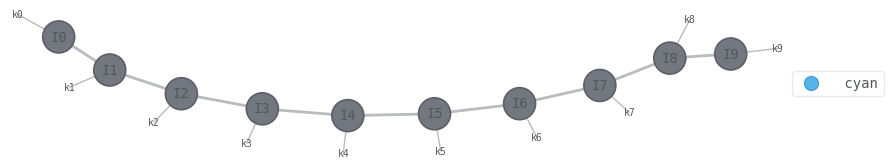

In [9]:
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt


qubits = 10
bond_dim = 4

# Random MPS state initialization
mps = qtn.MPS_rand_state(L=qubits, bond_dim=bond_dim)

# Contract to full state ()
full_state = mps.to_dense()

print("Full state shape:", full_state.shape)
print("State norm:", np.linalg.norm(full_state))

# Graphical representation
mps.draw(color=['cyan'], figsize=(10, 3))
plt.show()


In [10]:
"""
    compress_state_at_bond(mps, d, D_new, site, direction)

compresses the dimensions of the bond index connecting sites site and site+1 to D_new
"""
def compress_state_at_bond(mps, d, D_new, site, direction):
    indices_left = mps[site].shape
    indices_right = mps[site+1].shape

    M_l_lplus1 = np.zeros((indices_left[0], indices_left[1], indices_right[1], indices_right[2]))
    m_l = mps[site]
    m_lplus1 = mps[site + 1]

    mps[site] = np.zeros((indices_left[0], indices_left[1], min(D_new, indices_left[2])))
    mps[site+1] = np.zeros((min(D_new,indices_right[0]), indices_right[1], indices_right[2]))
    indices_left = mps[site].shape
    indices_right = mps[site+1].shape

    # M_l_lplus1[a_lminus1, σ_l, σ_lplus1, a_lplus1] := m_l[a_lminus1, σ_l, a_l] * m_lplus1[a_l, σ_lplus1, a_lplus1]
    M_l_lplus1= np.tensordot(m_l, m_lplus1, axes=([2],[0]))
    M_l_lplus1 = M_l_lplus1.reshape(indices_left[0] * indices_left[1], indices_right[1] * indices_right[2])
    U,s,Vt = np.linalg.svd(M_l_lplus1, full_matrices=False)

    if direction == "toRight":
        mps[site] = U[:,:indices_left[-1]].reshape(indices_left)
        #print(np.diag(s[0:indices_right[0]]).shape,Vt[0:indices_right[0], :].shape)
        sv_dagger = np.dot(np.diag(s[0:indices_right[0]]),Vt[0:indices_right[0], :])
        mps[site+1] = sv_dagger.reshape(indices_right)
    if direction == "toLeft":
        mps[site+1] = Vt[:indices_left[-1], :].reshape(indices_right)
        us = np.dot(U[: , 0:indices_right[0]], np.diag(s)[0:indices_right[0]])
        mps[site] = us.reshape(indices_left)
    truncation_weight = np.sum(s[(indices_right[0])+1:]**2) / sum(s[:]**2)
    #print(D_new,truncation_weight)
    return truncation_weight


In [11]:
import numpy as np
from tensorflow.keras.datasets import mnist
from icecream import ic
import copy

# Load MNIST data
(train_images, _), _ = mnist.load_data()

mnist_img = train_images[0]
img_normalized = mnist_img / 255.0

# Flatten to 1D vector
vector = img_normalized.flatten()

# Normalize (L2-norm)
vector_norm = np.linalg.norm(vector)
vector_normalized = vector / vector_norm

# Pad to length 1024 (2^10)
pad_length = 1024 - vector_normalized.size
mnist_vector_padded = np.pad(vector_normalized, (0, pad_length), 'constant')

# Final normalization
mnist_vector_padded /= np.linalg.norm(mnist_vector_padded)
assert np.isclose(np.sum(np.abs(mnist_vector_padded)**2), 1.0), "Not normalized"

ic(mnist_vector_padded.shape)

# Parameters for MPS
L = 10
d = 2
D_max = 4

# Convert state vector into tensor for decomposition
mnist_psi_tensor = mnist_vector_padded.reshape([d] * L)

# Function to create MPS from state vector (exact decomposition initially)
def vector_to_mps(psi_tensor, d, L):
  mps = {}
  psi = psi_tensor.copy()
  bond_dim = 1  # initial bond dimension

  for site in range(1, L):
      psi = psi.reshape(bond_dim * d, -1)
      U, s, Vt = np.linalg.svd(psi, full_matrices=False)

      # New bond dimension after this SVD step
      chi = len(s)

      # Assign MPS tensor for current site
      mps[site] = U.reshape(bond_dim, d, chi)

      # Prepare psi for next step (contract singular values into Vt)
      psi = np.dot(np.diag(s), Vt)

      # Update bond dimension for next iteration
      bond_dim = chi

  # Last site
  mps[L] = psi.reshape(bond_dim, d, 1)

  return mps


# Convert to exact MPS
mnist_mps = vector_to_mps(mnist_psi_tensor, d, L)

# Compress MPS to smaller bond dimension
D_compressed = 6
truncation_errors = []

for site in range(1, L):
    error = compress_state_at_bond(mnist_mps, d, 4, site, "toRight")
    truncation_errors.append(error)

ic(truncation_errors)

# Check shapes
for site in range(1, L+1):
    ic(site, mnist_mps[site].shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


ic| mnist_vector_padded.shape: (1024,)
ic| truncation_errors: [np.float64(0.0),
                        np.float64(0.0),
                        np.float64(0.3749999999999999),
                        np.float64(0.37499999999999994),
                        np.float64(0.18567850857468113),
                        np.float64(0.1800015486190697),
                        np.float64(0.029927698772535146),
                        np.float64(0.0),
                        np.float64(0.0)]
ic| site: 1, mnist_mps[site].shape: (1, 2, 2)
ic| site: 2, mnist_mps[site].shape: (2, 2, 4)
ic| site: 3, mnist_mps[site].shape: (4, 2, 4)
ic| site: 4, mnist_mps[site].shape: (4, 2, 4)
ic| site: 5, mnist_mps[site].shape: (4, 2, 4)
ic| site: 6, mnist_mps[site].shape: (4, 2, 4)
ic| site: 7, mnist_mps[site].shape: (4, 2, 4)
ic| site: 8, mnist_mps[site].shape: (4, 2, 4)
ic| site: 9, mnist_mps[site].shape: (4, 2, 2)
ic| site: 10, mnist_mps[site].shape: (2, 2, 1)


In [ ]:
'''
import numpy as np

def vector_to_exact_MPS(state_vector, num_qubits):
  d = 2
  mps = {}

  tensor = state_vector.reshape([d] * num_qubits)

  left_dim = 1

  for site in range(1, num_qubits):
    tensor_shape = tensor.shape
    ic(tensor_shape)
    tensor = tensor.reshape(left_dim * d, -1)

    U, S, V_dagger = np.linalg.svd(tensor, full_matrices=False)
    # Truncation missing
    bond_dim = S.size
    mps[site] = U.reshape(left_dim, d, bond_dim)
    left_dim = bond_dim

    tensor = np.dot(np.diag(S), V_dagger)

  mps[num_qubits] = tensor.reshape(left_dim, d, 1)

  return mps

# Generate exact MPS
num_qubits = 10
mps_tensors = vector_to_exact_MPS(vector_padded, num_qubits)

# Print tensor shapes to verify correctness
for idx in range(1, num_qubits + 1):
  test_str = "MPS tensor {index} shape: {shapes}".format(index=idx, shapes=mps_tensors[idx].shape)
  ic(test_str)
'''

ic| tensor_shape: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ic| tensor_shape: (2, 512)
ic| tensor_shape: (4, 256)
ic| tensor_shape: (8, 128)
ic| tensor_shape: (16, 64)
ic| tensor_shape: (32, 32)
ic| tensor_shape: (16, 16)
ic| tensor_shape: (8, 8)
ic| tensor_shape: (4, 4)
ic| test_str: 'MPS tensor 1 shape: (1, 2, 2)'
ic| test_str: 'MPS tensor 2 shape: (2, 2, 4)'
ic| test_str: 'MPS tensor 3 shape: (4, 2, 8)'
ic| test_str: 'MPS tensor 4 shape: (8, 2, 16)'
ic| test_str: 'MPS tensor 5 shape: (16, 2, 32)'
ic| test_str: 'MPS tensor 6 shape: (32, 2, 16)'
ic| test_str: 'MPS tensor 7 shape: (16, 2, 8)'
ic| test_str: 'MPS tensor 8 shape: (8, 2, 4)'
ic| test_str: 'MPS tensor 9 shape: (4, 2, 2)'
ic| test_str: 'MPS tensor 10 shape: (2, 2, 1)'


In [12]:
mnist_mps_tensors = vector_to_mps(mnist_psi_tensor, d, L)

def reconstruct_from_MPS(mps, L):
  psi = mps[1]
  print(f"Initial tensor shape (site 1): {psi.shape}")
  for site in range(2, L+1):
    print(f"Before contracting site {site}: psi shape={psi.shape}, next tensor shape={mps[site].shape}")
    psi = np.tensordot(psi, mps[site], axes=[-1, 0])
    print(f"After contracting site {site}, new psi shape: {psi.shape}")

  psi = psi.reshape(-1)
  return psi


mnist_reconstructed_vector = reconstruct_from_MPS(mnist_mps_tensors, 10)

ic(mnist_reconstructed_vector)
ic(mnist_reconstructed_vector.shape)

ic| mnist_reconstructed_vector: array([ 9.53855494e-17, -4.63089738e-18, -1.62990982e-17, ...,
                                        1.17869054e-17, -3.48320777e-18, -7.15986572e-19])


Initial tensor shape (site 1): (1, 2, 2)
Before contracting site 2: psi shape=(1, 2, 2), next tensor shape=(2, 2, 4)
After contracting site 2, new psi shape: (1, 2, 2, 4)
Before contracting site 3: psi shape=(1, 2, 2, 4), next tensor shape=(4, 2, 8)
After contracting site 3, new psi shape: (1, 2, 2, 2, 8)
Before contracting site 4: psi shape=(1, 2, 2, 2, 8), next tensor shape=(8, 2, 16)
After contracting site 4, new psi shape: (1, 2, 2, 2, 2, 16)
Before contracting site 5: psi shape=(1, 2, 2, 2, 2, 16), next tensor shape=(16, 2, 32)
After contracting site 5, new psi shape: (1, 2, 2, 2, 2, 2, 32)
Before contracting site 6: psi shape=(1, 2, 2, 2, 2, 2, 32), next tensor shape=(32, 2, 16)
After contracting site 6, new psi shape: (1, 2, 2, 2, 2, 2, 2, 16)
Before contracting site 7: psi shape=(1, 2, 2, 2, 2, 2, 2, 16), next tensor shape=(16, 2, 8)
After contracting site 7, new psi shape: (1, 2, 2, 2, 2, 2, 2, 2, 8)
Before contracting site 8: psi shape=(1, 2, 2, 2, 2, 2, 2, 2, 8), next tensor

ic| mnist_reconstructed_vector.shape: (1024,)


(1024,)

In [13]:
def reconstruct_from_MPS(mps, L):
  psi = mps[1]
  print(f"Initial tensor shape (site 1): {psi.shape}")
  for site in range(2, L+1):
    print(f"Before contracting site {site}: psi shape={psi.shape}, next tensor shape={mps[site].shape}")
    psi = np.tensordot(psi, mps[site], axes=[-1, 0])
    print(f"After contracting site {site}, new psi shape: {psi.shape}")

  psi = psi.reshape(-1)
  return psi



ic| original_size_bytes: 8192
ic| compressed_size_bytes: 8192


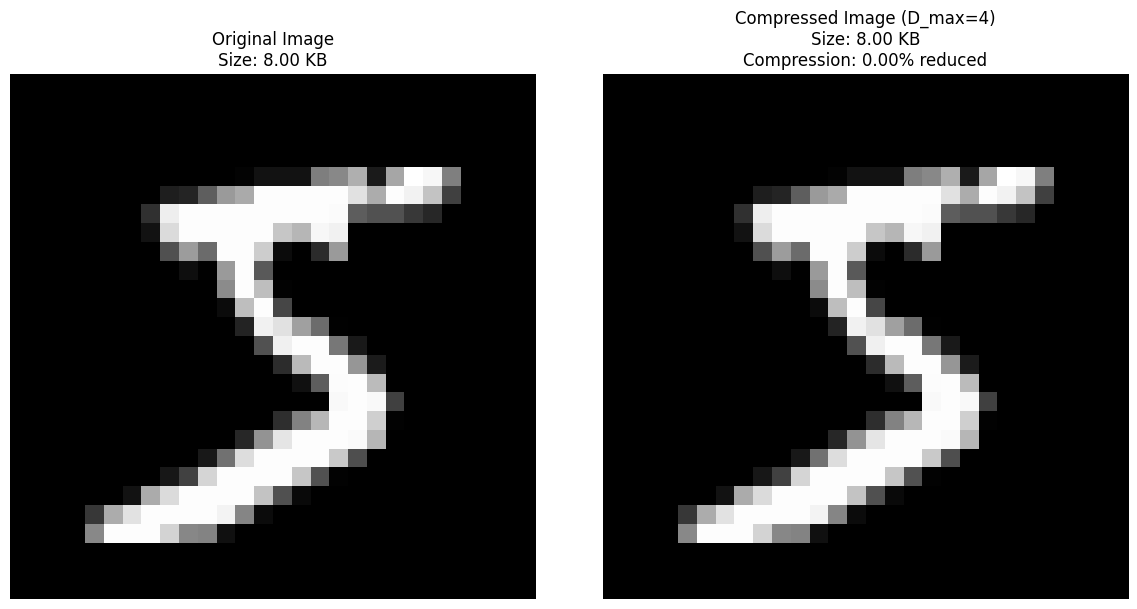

Original size: 8192 bytes
Compressed size: 8192 bytes
Compression ratio: 1.0000 (0.00% reduction)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def quantum_state_to_image(state_vector, original_shape=(28, 28)):
    required_size = original_shape[0] * original_shape[1]

    if len(state_vector) < required_size:
        error_str = f"State vector is too small ({len(state_vector)}) to reshape into {original_shape}. "
        error_str += "Try increasing D_max to retain more information."
        raise ValueError(error_str)

    image = np.abs(state_vector[:required_size])

    min_val, max_val = image.min(), image.max()
    if max_val - min_val == 0:
        image = np.zeros_like(image)
    else:
        image = (image - min_val) / (max_val - min_val)

    return image.reshape(original_shape)

# Convert original and compressed quantum states back to images
original_image = quantum_state_to_image(mnist_vector_padded)
compressed_image = quantum_state_to_image(mnist_reconstructed_vector)

# Calculate sizes in bytes
original_size_bytes = mnist_vector_padded.size * mnist_vector_padded.itemsize
compressed_size_bytes = mnist_reconstructed_vector.size * mnist_reconstructed_vector.itemsize

compression_ratio = compressed_size_bytes / original_size_bytes
size_reduction_percentage = (1 - compression_ratio) * 100
ic(original_size_bytes)
ic(compressed_size_bytes)
# Plot before and after compression with size details
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(original_image, cmap='gray')
ax[0].set_title(f"Original Image\nSize: {original_size_bytes / 1024:.2f} KB")
ax[0].axis('off')

ax[1].imshow(compressed_image, cmap='gray')
ax[1].set_title(f"Compressed Image (D_max={D_max})\n"
                f"Size: {compressed_size_bytes / 1024:.2f} KB\n"
                f"Compression: {size_reduction_percentage:.2f}% reduced")
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Print detailed information
print(f"Original size: {original_size_bytes} bytes")
print(f"Compressed size: {compressed_size_bytes} bytes")
print(f"Compression ratio: {compression_ratio:.4f} "
      f"({size_reduction_percentage:.2f}% reduction)")


### Could not compress after doing multiple tries, differrent approaches, different D_compressed

### Let's try with a bigger image, so there is more room for compression

In [16]:
lenna_img = plt.imread("/content/38.jpg")

import numpy as np

# Assuming img is a 512x512 grayscale image already loaded:
img_normalized = lenna_img / 255.0

# Flatten image to 1D array
vector = img_normalized.flatten()

# Compute L2-norm for normalization
vector_norm = np.linalg.norm(vector)
img_vector_normalized = vector / vector_norm

# Check the size
print(f"Original vector size: {vector.size}")

# Confirm normalization
img_vector_normalized /= np.linalg.norm(vector_normalized)
assert np.isclose(np.sum(np.abs(vector_normalized)**2), 1.0), "Not normalized"


Original vector size: 262144


In [17]:
L = 18        # since 2^18 = 262144 amplitudes
d = 2
D_max = 160
D_compressed = 160


psi_tensor = img_vector_normalized.reshape([d] * L)
image_mps = vector_to_mps(psi_tensor, d, L)



for site in range(1, L):
  center_bias = int(D_max * np.sin(np.pi * site / L))  # smoothly grows and shrinks
  compress_state_at_bond(image_mps, d, max(4, center_bias), site, direction="toRight")

# Check shapes
for site in range(1, L+1):
  ic(site, image_mps[site].shape)

ic| site: 1, image_mps[site].shape: (1, 2, 2)
ic| site: 2, image_mps[site].shape: (2, 2, 4)
ic| site: 3, image_mps[site].shape: (4, 2, 8)
ic| site: 4, image_mps[site].shape: (8, 2, 16)
ic| site: 5, image_mps[site].shape: (16, 2, 32)
ic| site: 6, image_mps[site].shape: (32, 2, 64)
ic| site: 7, image_mps[site].shape: (64, 2, 128)
ic| site: 8, image_mps[site].shape: (128, 2, 157)
ic| site: 9, image_mps[site].shape: (157, 2, 160)
ic| site: 10, image_mps[site].shape: (160, 2, 157)
ic| site: 11, image_mps[site].shape: (157, 2, 128)
ic| site: 12, image_mps[site].shape: (128, 2, 64)
ic| site: 13, image_mps[site].shape: (64, 2, 32)
ic| site: 14, image_mps[site].shape: (32, 2, 16)
ic| site: 15, image_mps[site].shape: (16, 2, 8)
ic| site: 16, image_mps[site].shape: (8, 2, 4)
ic| site: 17, image_mps[site].shape: (4, 2, 2)
ic| site: 18, image_mps[site].shape: (2, 2, 1)


In [18]:
def reconstruct_from_MPS(mps, L):
  psi = mps[1]

  for site in range(2, L + 1):
      psi = np.tensordot(psi, mps[site], axes=[-1, 0])

  psi = np.reshape(psi, (-1,))
  return psi


In [19]:
# Reconstruction from MPS to vector format
img_reconstructed = reconstruct_from_MPS(image_mps, L)
ic(img_reconstructed.shape)

ic| img_reconstructed.shape: (262144,)


(262144,)

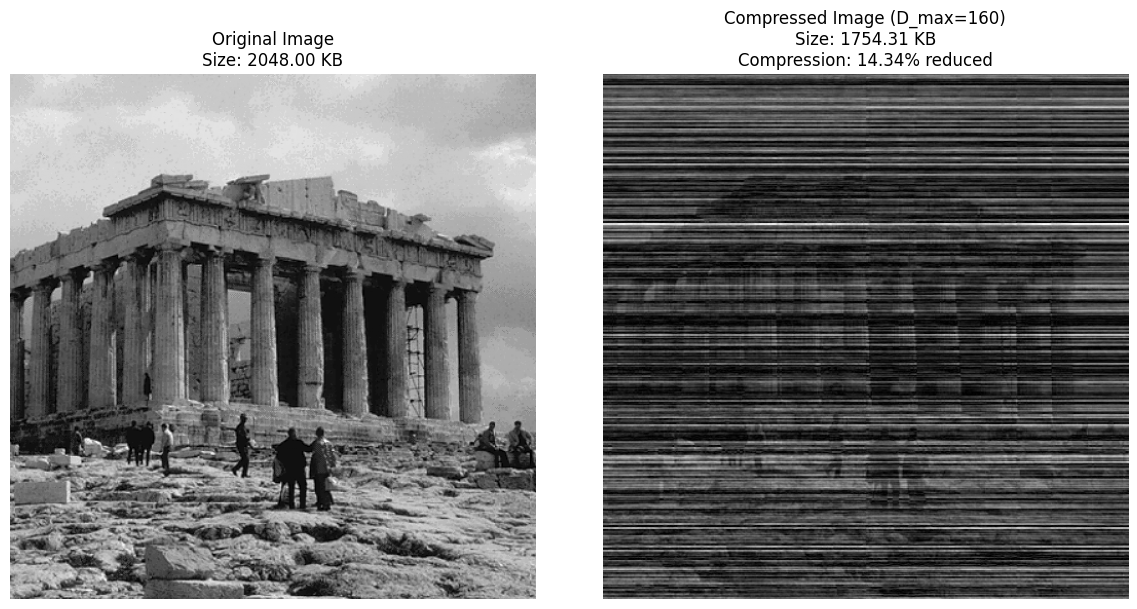

Original size: 2097152 bytes
Compressed size (MPS tensors): 1796416 bytes
Compression ratio: 0.8566 (14.34% reduction)


In [20]:

'''def mps_to_vector(mps, L):
  psi = mps[1]
  for site in range(2, L+1):
    psi = np.tensordot(psi, mps[site], axes=([psi.ndim -1  ], [0]))
  return psi.reshape(-1)

# Reconstruct vector from compressed MPS
img_reconstructed = mps_to_vector(image_mps, L)
 '''

def quantum_state_to_image(state_vector, original_shape=(512, 512)):
  image = np.abs(state_vector[:np.prod(original_shape)])

  # Normalize
  min_val, max_val = image.min(), image.max()
  if max_val - min_val > 0:
    image = (image - min_val) / (max_val - min_val)
  else:
    image = np.zeros_like(image)

  return image.reshape(original_shape)

# Convert original and compressed quantum states back to images
original_image = quantum_state_to_image(img_vector_normalized, original_shape=(512, 512))
compressed_image = quantum_state_to_image(img_reconstructed, original_shape=(512, 512))

# Calculate sizes in bytes (original MPS vs compressed MPS)
original_size_bytes = img_vector_normalized.size * img_vector_normalized.itemsize
compressed_size_bytes = sum(tensor.size * tensor.itemsize for tensor in image_mps.values())

compression_ratio = compressed_size_bytes / original_size_bytes
size_reduction_percentage = (1 - compression_ratio) * 100

# Plot before and after compression with size details
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(original_image, cmap='gray')
ax[0].set_title(f"Original Image\nSize: {original_size_bytes / 1024:.2f} KB")
ax[0].axis('off')

ax[1].imshow(compressed_image, cmap='gray')
ax[1].set_title(f"Compressed Image (D_max={D_compressed})\n"
                f"Size: {compressed_size_bytes / 1024:.2f} KB\n"
                f"Compression: {size_reduction_percentage:.2f}% reduced")
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Print sizes
print(f"Original size: {original_size_bytes} bytes")
print(f"Compressed size (MPS tensors): {compressed_size_bytes} bytes")
print(f"Compression ratio: {compression_ratio:.4f} "
      f"({size_reduction_percentage:.2f}% reduction)")


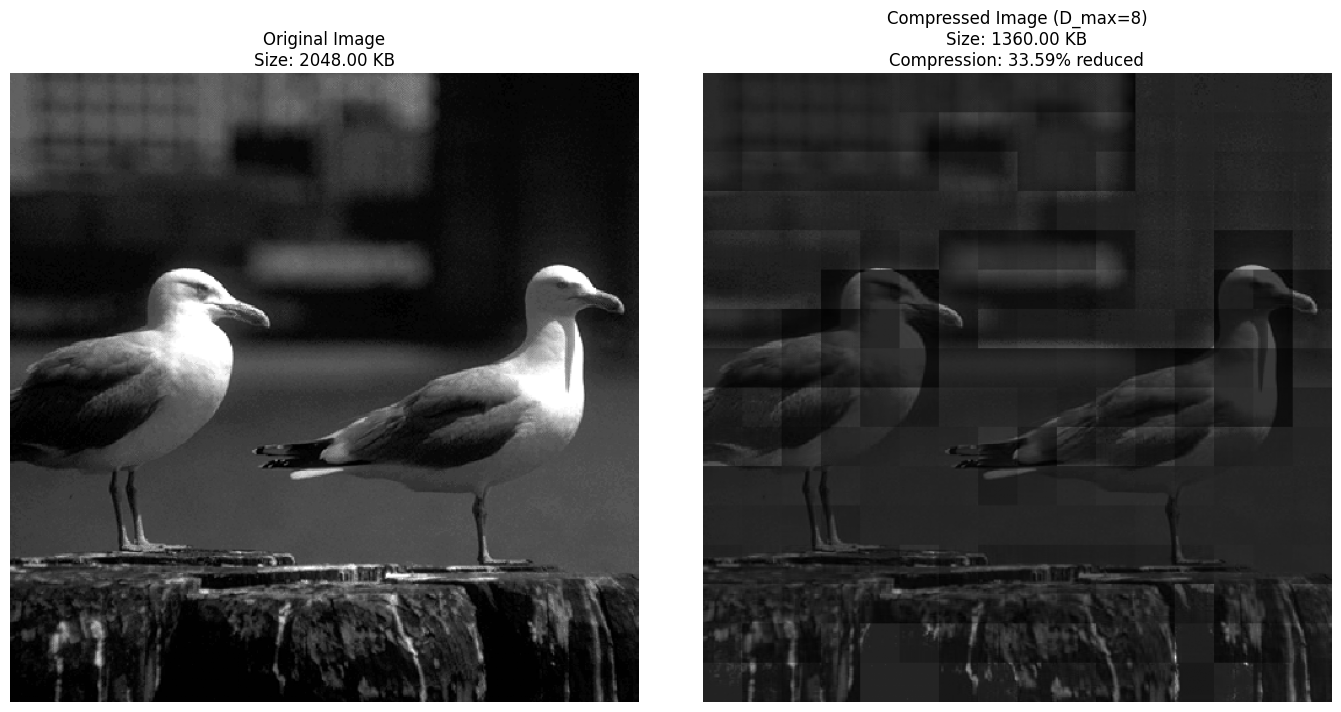

ic| ssim(original_image, compressed_image, data_range=compressed_image.max() - compressed_image.min()): np.float64(0.0897063093526647)


Original size: 2097152 bytes
Compressed size (Block-wise MPS tensors): 1392640 bytes
Compression ratio: 0.6641 (33.59% reduction)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def split_into_blocks(image, block_size):
  blocks = []
  h, w = image.shape
  for i in range(0, h, block_size):
    for j in range(0, w, block_size):
      blocks.append(image[i:i+block_size, j:j+block_size])
  return blocks

def vector_to_mps(psi_tensor, d, L, D_max):
  mps = {}
  psi = psi_tensor.copy()
  bond_dim = 1

  for site in range(1, L):
    psi = psi.reshape(bond_dim * d, -1)
    U, s, Vt = np.linalg.svd(psi, full_matrices=False)
    chi = min(len(s), D_max)
    U = U[:, :chi]
    s = s[:chi]
    Vt = Vt[:chi, :]
    mps[site] = U.reshape(bond_dim, d, chi)
    psi = np.dot(np.diag(s), Vt)
    bond_dim = chi

  mps[L] = psi.reshape(bond_dim, d, 1)
  return mps


def compress_state_at_bond(mps, d, D_new, site, direction):
  M_l_lplus1 = np.tensordot(mps[site], mps[site+1], axes=([2],[0]))
  left_shape = mps[site].shape
  right_shape = mps[site+1].shape

  M_l_lplus1 = M_l_lplus1.reshape(left_shape[0]*left_shape[1], -1)
  U, s, Vt = np.linalg.svd(M_l_lplus1, full_matrices=False)

  chi = min(D_new, len(s))
  U = U[:, :chi]
  s = s[:chi]
  Vt = Vt[:chi, :]

  truncation_error = np.sum(s[chi:]**2) / np.sum(s**2) if chi < len(s) else 0

  if direction == "toRight":
    mps[site] = U.reshape(left_shape[0], left_shape[1], chi)
    mps[site+1] = np.dot(np.diag(s), Vt).reshape(chi, right_shape[1], right_shape[2])

  return truncation_error


def reconstruct_from_MPS(mps, L):
  psi = mps[1]
  for site in range(2, L + 1):
    psi = np.tensordot(psi, mps[site], axes=[-1, 0])
  return psi.reshape(-1)

def compress_block(block, D_max):
  block_vector = block.flatten()
  block_vector /= np.linalg.norm(block_vector)

  L_block = int(np.ceil(np.log2(block_vector.size)))
  padded_size = 2 ** L_block
  padding = padded_size - block_vector.size
  block_vector = np.pad(block_vector, (0, padding), 'constant')

  psi_tensor = block_vector.reshape([2]*L_block)
  block_mps = vector_to_mps(psi_tensor, d=2, L=L_block, D_max=D_max)

  for site in range(1, L_block):
    adaptive_D = min(D_max, 2**min(site, L_block - site, 4))
    compress_state_at_bond(block_mps, d=2, D_new=adaptive_D, site=site, direction='toRight')

  return block_mps



def reconstruct_block(mps_block):
  L_block = len(mps_block)
  vec = reconstruct_from_MPS(mps_block, L_block)
  vec /= np.linalg.norm(vec)

  block_side = int(np.sqrt(vec.size))
  return vec.reshape((block_side, block_side))

def stitch_blocks(blocks, image_shape, block_size):
  stitched_image = np.zeros(image_shape)
  h_blocks = image_shape[0] // block_size
  w_blocks = image_shape[1] // block_size

  idx = 0
  for i in range(h_blocks):
    for j in range(w_blocks):
      stitched_image[
          i*block_size:(i+1)*block_size,
          j*block_size:(j+1)*block_size
      ] = blocks[idx][:block_size, :block_size]
      idx += 1

  return stitched_image

def mps_size_in_bytes(mps):
  return sum(tensor.size * tensor.itemsize for tensor in mps.values())

# Parameters
block_size = 32
D_max_block = 8 # BEST TRY until now 8

new_img = plt.imread('/content/27.jpg')

# Assume img is in grayscalee
original_image = new_img / 255.0

# Original size in bytes
original_size_bytes = original_image.size * original_image.itemsize

# Compress and reconstruct the image using block-wise MPS
blocks = split_into_blocks(original_image, block_size)
compressed_mps_blocks = [compress_block(block, D_max_block) for block in blocks]

# Calculate compressed size
compressed_size_bytes = sum(mps_size_in_bytes(mps_block) for mps_block in compressed_mps_blocks)

# Compression ratio and percentage
compression_ratio = compressed_size_bytes / original_size_bytes
compression_percentage = (1 - compression_ratio) * 100


reconstructed_blocks = [reconstruct_block(mps_block) for mps_block in compressed_mps_blocks]
compressed_image = stitch_blocks(reconstructed_blocks, original_image.shape, block_size)

metrics_block_image = compressed_image  # Label change for use of metrics later

fig, ax = plt.subplots(1, 2, figsize=(14, 7))


# Original Image
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title(f'Original Image\nSize: {original_size_bytes / 1024:.2f} KB')
ax[0].axis('off')

# Compressed Image
ax[1].imshow(compressed_image, cmap='gray')
ax[1].set_title(f'Compressed Image (D_max={D_max_block})\n'
                f'Size: {compressed_size_bytes / 1024:.2f} KB\n'
                f'Compression: {compression_percentage:.2f}% reduced')
ax[1].axis('off')

plt.tight_layout()
plt.show()
ic(ssim(original_image, compressed_image, data_range=compressed_image.max() - compressed_image.min()))
print(f"Original size: {original_size_bytes} bytes")
print(f"Compressed size (Block-wise MPS tensors): {compressed_size_bytes} bytes")
print(f"Compression ratio: {compression_ratio:.4f} "
      f"({compression_percentage:.2f}% reduction)")

## New version of MPS representation (no trucation)

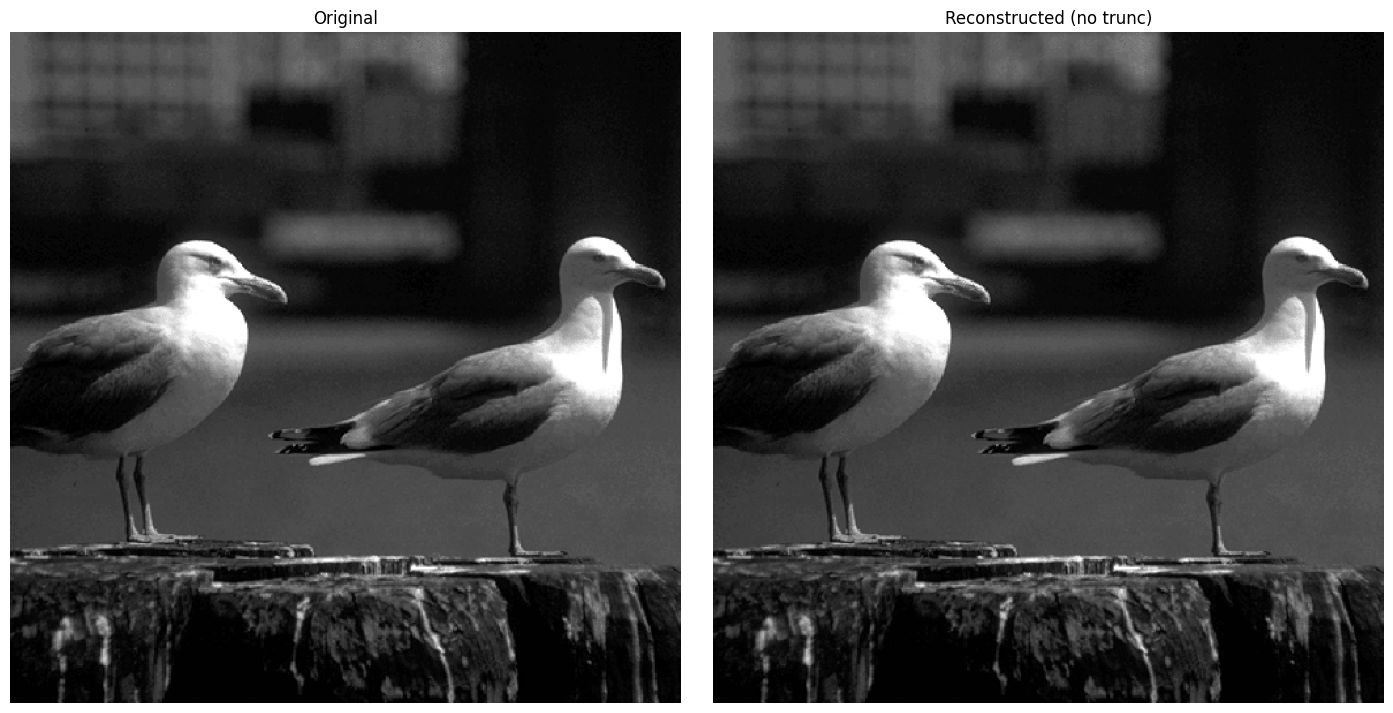

SSIM  : 0.999999
PSNR  : 140.43 dB
Orig bytes : 1048576
MPS  bytes : 2793472
Compression: -166.41% (negative ⇒ larger than original)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from icecream import ic                 # optional debug prints

# ------------------------------------------------------------
# 1) Helpers for block tiling / stitching
# ------------------------------------------------------------
def split_into_blocks(img, bs):
    h, w = img.shape
    return [
        img[i:i+bs, j:j+bs]
        for i in range(0, h, bs)
        for j in range(0, w, bs)
    ]

def blocks_to_image(blocks, img_shape, bs):
    h, w = img_shape
    out = np.zeros(img_shape, dtype=blocks[0].dtype)
    k = 0
    for bi in range(0, h, bs):
        for bj in range(0, w, bs):
            out[bi:bi+bs, bj:bj+bs] = blocks[k][:bs, :bs]
            k += 1
    return out

# ------------------------------------------------------------
# 2) MPS routines (full‑rank, no truncation)
# ------------------------------------------------------------
def vector_to_mps_full(tensor, d, L):
    """Build an MPS keeping *all* singular values."""
    mps, psi, bond = {}, tensor.copy(), 1
    for site in range(1, L):
        psi = psi.reshape(bond * d, -1)
        U, s, Vt = np.linalg.svd(psi, full_matrices=False)
        chi = len(s)                       # keep everything
        mps[site] = U.reshape(bond, d, chi)
        psi = np.dot(np.diag(s), Vt)
        bond = chi
    mps[L] = psi.reshape(bond, d, 1)
    return mps

def reconstruct_from_MPS(mps, L):
    psi = mps[1]
    for site in range(2, L+1):
        psi = np.tensordot(psi, mps[site], axes=[-1, 0])
    return psi.reshape(-1)

def mps_size_bytes(mps):
    return sum(t.size * t.itemsize for t in mps.values())

# ------------------------------------------------------------
# 3) Block compression / reconstruction (NO TRUNCATION, NO RE‑NORM)
# ------------------------------------------------------------
def compress_block_no_trunc(block):
    vec = block.flatten()                       # keep original scale
    L = int(np.ceil(np.log2(vec.size)))
    pad = 2**L - vec.size                       # zero‑pad to power of 2
    vec = np.pad(vec, (0, pad))
    psi = vec.reshape([2]*L)
    return vector_to_mps_full(psi, d=2, L=L), pad, block.shape

def reconstruct_block(mps, pad, orig_shape):
    L = len(mps)
    vec = reconstruct_from_MPS(mps, L)
    if pad:
        vec = vec[:-pad]                        # remove padding
    return vec.reshape(orig_shape)

# ------------------------------------------------------------
# 4) Pipeline
# ------------------------------------------------------------
block_size         = 32
new_img            = plt.imread('/content/27.jpg')
original_image     = new_img.astype(np.float32) / 255.0    # grayscale [0,1]

orig_bytes         = original_image.size * original_image.itemsize

# ---- compress each block (no truncation) ----
mps_blocks, pads, shapes = [], [], []
for blk in split_into_blocks(original_image, block_size):
    mps, pad, shp = compress_block_no_trunc(blk)
    mps_blocks.append(mps); pads.append(pad); shapes.append(shp)

comp_bytes = sum(mps_size_bytes(m) for m in mps_blocks)
saving     = (1 - comp_bytes / orig_bytes) * 100

# ---- reconstruct full image ----
recon_blocks = [
    reconstruct_block(mps_blocks[i], pads[i], shapes[i])
    for i in range(len(mps_blocks))
]
reconstructed = blocks_to_image(recon_blocks, original_image.shape, block_size)

# ---- Metrics ----
dr     = original_image.max() - original_image.min()
ssim_v = ssim(original_image, reconstructed, data_range=dr)
psnr_v = psnr(original_image, reconstructed, data_range=dr)

# ------------------------------------------------------------
# 5) Display & report
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)
ax[0].imshow(original_image, cmap='gray'); ax[0].set_title("Original");   ax[0].axis('off')
ax[1].imshow(reconstructed , cmap='gray'); ax[1].set_title("Reconstructed (no trunc)"); ax[1].axis('off')
plt.show()

print(f"SSIM  : {ssim_v:.6f}")
print(f"PSNR  : {psnr_v:.2f} dB")
print(f"Orig bytes : {orig_bytes}")
print(f"MPS  bytes : {comp_bytes}")
print(f"Compression: {saving:.2f}% (negative ⇒ larger than original)")


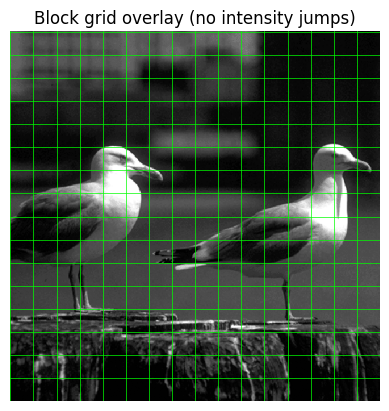

In [28]:
plt.imshow(reconstructed, cmap='gray')
for y in range(0, reconstructed.shape[0], block_size):
    plt.axhline(y, color='lime', lw=0.5)
for x in range(0, reconstructed.shape[1], block_size):
    plt.axvline(x, color='lime', lw=0.5)
plt.title("Block grid overlay (no intensity jumps)")
plt.axis('off')
plt.show()


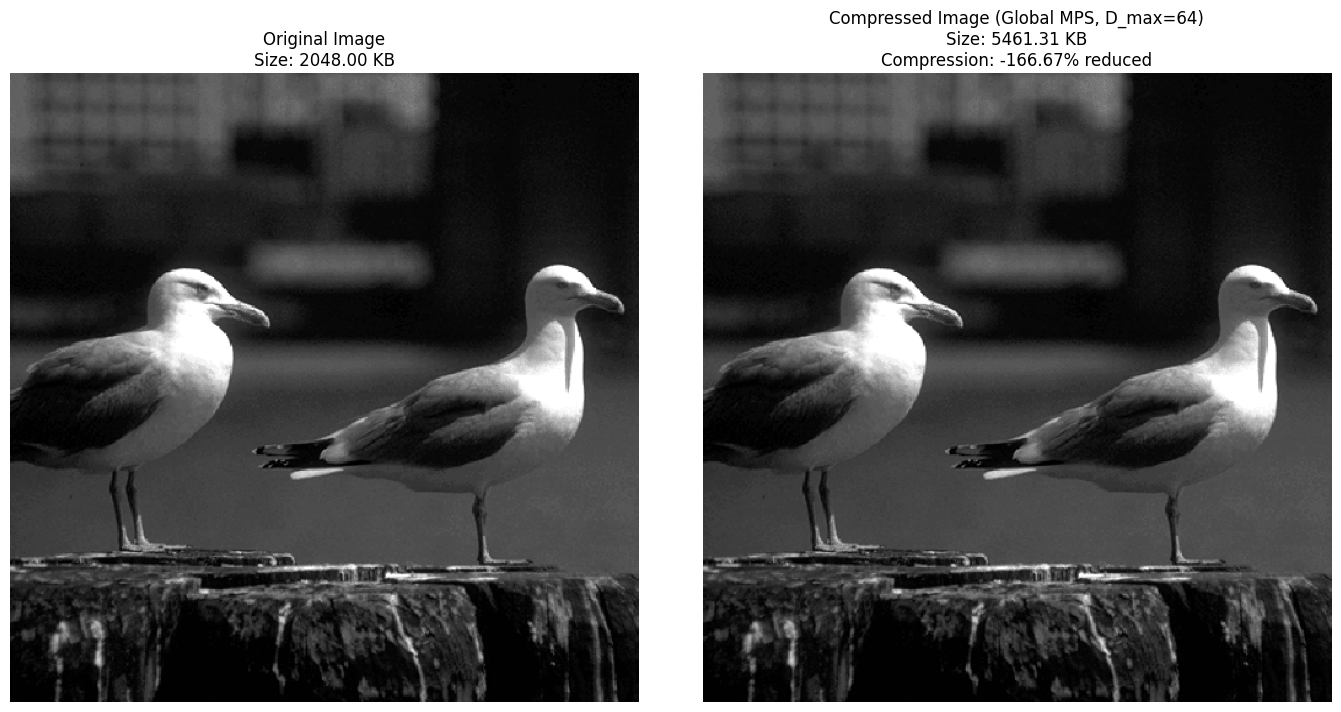

Original size: 2097152 bytes
Compressed size (Global MPS tensors): 5592384 bytes
Compression ratio: 2.6667 (-166.67% reduction)


In [23]:
import numpy as np
import matplotlib.pyplot as plt

'''
def vector_to_mps(psi_tensor, d, L, D_max):
  mps = {}
  psi = psi_tensor.copy()
  bond_dim = 1

  for site in range(1, L):
    psi = psi.reshape(bond_dim * d, -1)
    U, s, Vt = np.linalg.svd(psi, full_matrices=False)
    chi = min(len(s), D_max)
    U = U[:, :chi]
    s = s[:chi]
    Vt = Vt[:chi, :]
    mps[site] = U.reshape(bond_dim, d, chi)
    psi = np.dot(np.diag(s), Vt)

  mps[L] = psi.reshape(bond_dim, d, 1)
  return mps

def compress_state_at_bond(mps, d, D_new, site, direction):
  combined_tensor = np.tensordot(mps[site], mps[site+1], axes=([2],[0]))
  left_shape = mps[site].shape
  right_shape = mps[site+1].shape

  combined_tensor = combined_tensor.reshape(left_shape[0]*left_shape[1], -1)
  U, s, Vt = np.linalg.svd(combined_tensor, full_matrices=False)

  #chi = min(D_new, len(s))
  #U = U[:, :chi]
  #s = s[:chi]
  #Vt = Vt[:chi, :]

  truncation_error = np.sum(s[chi:]**2) / np.sum(s**2) if chi < len(s) else 0

  if direction == "toRight":
    mps[site] = U.reshape(left_shape[0], left_shape[1], chi)
    mps[site+1] = np.dot(np.diag(s), Vt).reshape(chi, right_shape[1], right_shape[2])

  return truncation_error
'''
def vector_to_mps(psi_tensor, d, L):
  import numpy as np
  mps = {}
  psi = psi_tensor.copy()
  bond_dim = 1

  for site in range(1, L):
    psi = psi.reshape(bond_dim * d, -1)
    U, s, Vt = np.linalg.svd(psi, full_matrices=False)
    chi = len(s)  # No truncation: keep full rank
    mps[site] = U.reshape(bond_dim, d, chi)
    psi = np.dot(np.diag(s), Vt)
    bond_dim = chi

  mps[L] = psi.reshape(bond_dim, d, 1)
  return mps

def compress_state_at_bond(mps, d, site, direction):
  left_shape = mps[site].shape
  right_shape = mps[site+1].shape

  # Contract tensors at bond
  combined_tensor = np.tensordot(mps[site], mps[site+1], axes=([2], [0]))
  combined_tensor = combined_tensor.reshape(left_shape[0]*left_shape[1], -1)

  # Full SVD
  U, s, Vt = np.linalg.svd(combined_tensor, full_matrices=False)
  chi = len(s)  # No truncation

  truncation_error = 0  # Since there's no truncation

  if direction == "toRight":
      mps[site] = U.reshape(left_shape[0], left_shape[1], chi)
      mps[site+1] = np.dot(np.diag(s), Vt).reshape(chi, right_shape[1], right_shape[2])

  return truncation_error

def reconstruct_from_MPS(mps, L):
  psi = mps[1]
  for site in range(2, L + 1):
    psi = np.tensordot(psi, mps[site], axes=[-1, 0])
  return psi.reshape(-1)

def mps_size_in_bytes(mps):
  return sum(tensor.size * tensor.itemsize for tensor in mps.values())


D_max_global = 64 # INIT was 128
# Load and normalize
# img = plt.imread('/content/38.jpg')
original_image = new_img / 255.0

# Original image size
original_size_bytes = original_image.size * original_image.itemsize

# Flatten image to vector fo compression
image_vector = original_image.flatten()
image_vector /= np.linalg.norm(image_vector)

# Prepare the tensor shape
L = int(np.log2(image_vector.size))
psi_tensor = image_vector.reshape([2]*L)

# Convert to MPS
#image_mps = vector_to_mps(psi_tensor, d=2, L=L, D_max=D_max_global)
image_mps = vector_to_mps(psi_tensor, d=2, L=L)

D_max_global = 64

'''
for site in range(1, L):
  # to make larger dimensions in the middle and smaller in the edges
  adaptive_D = min(D_max_global, 2**min(site, L - site, 8))
  compress_state_at_bond(image_mps, d=2, D_new=adaptive_D, site=site, direction='toRight')
'''
# Calculate compressed size
compressed_size_bytes = mps_size_in_bytes(image_mps)

# Reconstruct compressed image
reconstructed_vector = reconstruct_from_MPS(image_mps, L)
reconstructed_vector /= np.linalg.norm(reconstructed_vector)

compressed_image = reconstructed_vector.reshape(original_image.shape)
metrics_adaptive_image = compressed_image # Label to measure metrics later
# Calculate compression ratio and percentage
compression_ratio = compressed_size_bytes / original_size_bytes
compression_percentage = (1 - compression_ratio) * 100

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Original Image
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title(f'Original Image\nSize: {original_size_bytes / 1024:.2f} KB')
ax[0].axis('off')

# Compressed Image
ax[1].imshow(compressed_image, cmap='gray')
ax[1].set_title(f'Compressed Image (Global MPS, D_max={D_max_global})\n'
                f'Size: {compressed_size_bytes / 1024:.2f} KB\n'
                f'Compression: {compression_percentage:.2f}% reduced')
ax[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original size: {original_size_bytes} bytes")
print(f"Compressed size (Global MPS tensors): {compressed_size_bytes} bytes")
print(f"Compression ratio: {compression_ratio:.4f} "
      f"({compression_percentage:.2f}% reduction)")

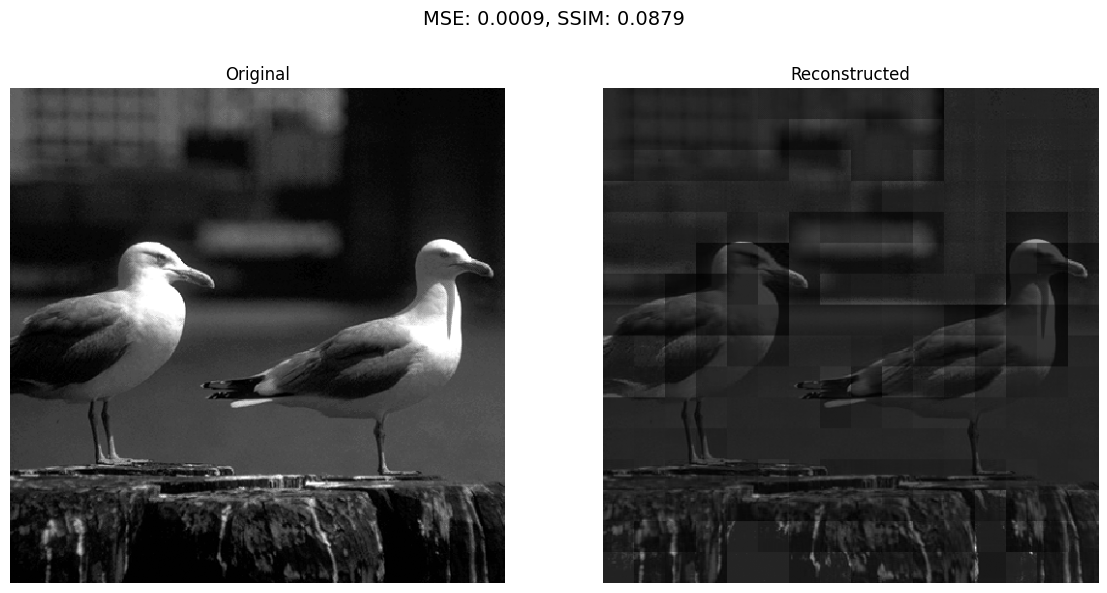

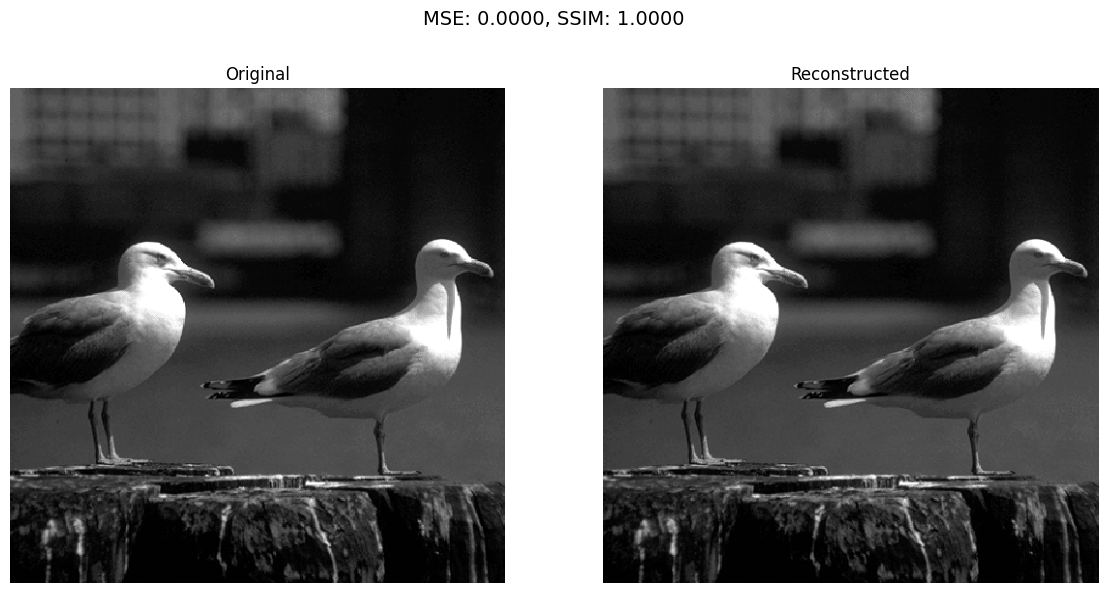

ic| original_image: array([[0.43921569, 0.43921569, 0.43921569, ..., 0.1254902 , 0.1254902 ,
                            0.1254902 ],
                           [0.43921569, 0.43921569, 0.43921569, ..., 0.09803922, 0.1254902 ,
                            0.1254902 ],
                           [0.43921569, 0.43921569, 0.43921569, ..., 0.1254902 , 0.1254902 ,
                            0.1254902 ],
                           ...,
                           [0.09803922, 0.09803922, 0.09803922, ..., 0.1254902 , 0.11764706,
                            0.11764706],
                           [0.09803922, 0.09803922, 0.09803922, ..., 0.10196078, 0.10196078,
                            0.10196078],
                           [0.09803922, 0.09803922, 0.09803922, ..., 0.11764706, 0.10196078,
                            0.10196078]])
ic| metrics_adaptive_image: array([[0.00261251, 0.00261251, 0.00261251, ..., 0.00074643, 0.00074643,
                                    0.00074643],
             

(512, 512)

In [24]:
from icecream import ic
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

def mse(input_img, compressed_img):
  return np.mean((input_img.astype("float") - compressed_img.astype("float")) ** 2)

def compare_image(input_img, compressed_img, title):
  input_img = input_img / np.linalg.norm(input_img)
  m = mse(input_img, compressed_img)
  data_range = max(input_img.max(), compressed_img.max()) - min(input_img.min(), compressed_img.min())
  s = ssim(input_img, compressed_img, data_range=data_range)

  fig = plt.figure(title, figsize=(12, 6))
  plt.suptitle("MSE: {:.4f}, SSIM: {:.4f}".format(m, s), fontsize=14)

  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(input_img, cmap='gray')
  ax.set_title("Original")
  ax.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(compressed_img, cmap='gray')
  ax.set_title("Reconstructed")
  ax.axis("off")

  plt.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.show()

  return m, s

# Example usage
compare_image(original_image, metrics_block_image, "Block-wise MPS")
compare_image(original_image, metrics_adaptive_image, "Global MPS")

ic(original_image)
ic(metrics_adaptive_image)
ic(metrics_adaptive_image.shape)

In [25]:
def image_to_blocks(image, block_size):
  h, w = image.shape
  return (image.reshape(h // block_size, block_size, -1, block_size)
                .swapaxes(1,2)
                .reshape(-1, block_size, block_size))

def blocks_to_image(blocks, image_shape, block_size):
  h, w = image_shape
  return (blocks.reshape(h // block_size, w // block_size, block_size, block_size)
                .swapaxes(1,2)
                .reshape(h, w))

block_size = 8
blocks = image_to_blocks(temp_original_image, block_size)
reconstructed_blocks = []

bond_dims_to_test = [2, 4, 8, 16, 32, 64, 128, 256]
ssim_vs_bond_dim = []
mse_vs_bond_dim = []

for test_D in bond_dims_to_test:
  reconstructed_blocks = []

  for block in blocks:
    psi_tensor, temp_L = prepare_psi_from_image(block)

    temp_mps = vector_to_mps(psi_tensor, d=2, L=temp_L, D_max=test_D)
    for site in range(1, temp_L):
      adaptive_D = min(test_D, 2**min(site, temp_L - site, 4))
      compress_state_at_bond(temp_mps, d=2, D_new=adaptive_D, site=site, direction='toRight')

    temp_reconstructed_vec = reconstruct_from_MPS(temp_mps, temp_L)
    temp_reconstructed_img = temp_reconstructed_vec.reshape(block.shape)

    reconstructed_blocks.append(temp_reconstructed_img)

  full_reconstructed_image = blocks_to_image(np.array(reconstructed_blocks), temp_original_image.shape, block_size)

  current_ssim = ssim(temp_original_image, full_reconstructed_image, data_range=temp_original_image.max() - temp_original_image.min())
  current_mse = np.mean((temp_original_image - full_reconstructed_image)**2)

  ssim_vs_bond_dim.append(current_ssim)
  mse_vs_bond_dim.append(current_mse)

# Plot the results
plt.figure(figsize=(10, 5))
plt.xscale('log', base=2)
plt.plot(bond_dims_to_test, ssim_vs_bond_dim, marker='o', label='SSIM')
plt.plot(bond_dims_to_test, mse_vs_bond_dim, marker='x', label='MSE')
plt.xlabel('D_max (Bond Dimension)')
plt.ylabel('Metric Value')
plt.title('SSIM & MSE vs. D_max (Block-wise MPS Compression)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'temp_original_image' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


def image_to_blocks(image, block_size):
    h, w = image.shape
    return (image.reshape(h // block_size, block_size, -1, block_size)
                 .swapaxes(1,2)
                 .reshape(-1, block_size, block_size))

def blocks_to_image(blocks, image_shape, block_size):
    h, w = image_shape
    return (blocks.reshape(h // block_size, w // block_size, block_size, block_size)
                  .swapaxes(1,2)
                  .reshape(h, w))

block_size = 16
blocks = image_to_blocks(temp_original_image, block_size)
bond_dims_to_test = [2, 4, 8, 16, 32, 64, 128, 256]

ssim_vs_bond_dim = []
mse_vs_bond_dim = []
psnr_vs_bond_dim = []

# --- Evaluation Loop ---
for test_D in bond_dims_to_test:
    reconstructed_blocks = []

    for block in blocks:
      psi_tensor, temp_L = prepare_psi_from_image(block)

      temp_mps = vector_to_mps(psi_tensor, d=2, L=temp_L, D_max=test_D)
      for site in range(1, temp_L):
        adaptive_D = min(test_D, 2**min(site, temp_L - site, 6))
        compress_state_at_bond(temp_mps, d=2, D_new=adaptive_D, site=site, direction='toRight')

      temp_reconstructed_vec = reconstruct_from_MPS(temp_mps, temp_L)
      temp_reconstructed_img = temp_reconstructed_vec.reshape(block.shape)
      print("D_max = {}, SSIM = {:.4f}, PSNR = {:.2f} dB, MSE = {:.5f}".format(test_D, current_ssim, current_psnr, current_mse))

      reconstructed_blocks.append(temp_reconstructed_img)

    full_reconstructed_image = blocks_to_image(np.array(reconstructed_blocks), temp_original_image.shape, block_size)

    # Compute metrics
    data_range = temp_original_image.max() - temp_original_image.min()
    current_ssim = ssim(temp_original_image, full_reconstructed_image, data_range=data_range)
    current_mse = np.mean((temp_original_image - full_reconstructed_image) ** 2)
    current_psnr = psnr(temp_original_image, full_reconstructed_image, data_range=data_range)

    ssim_vs_bond_dim.append(current_ssim)
    mse_vs_bond_dim.append(current_mse)
    psnr_vs_bond_dim.append(current_psnr)

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.xscale('log', base=2)

plt.plot(bond_dims_to_test, ssim_vs_bond_dim, marker='o', label='SSIM')
plt.plot(bond_dims_to_test, mse_vs_bond_dim, marker='x', label='MSE')
plt.plot(bond_dims_to_test, psnr_vs_bond_dim, marker='s', label='PSNR (dB)')

plt.xlabel('D_max (Bond Dimension)')
plt.ylabel('Metric Value')
plt.title('SSIM, MSE, and PSNR vs. D_max (Block-wise MPS Compression)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'current_psnr' is not defined

D_max = 2, SSIM = 0.0110, MSE = 0.10675, PSNR = 8.86 dB
D_max = 4, SSIM = 0.0099, MSE = 0.10664, PSNR = 8.86 dB
D_max = 8, SSIM = 0.0095, MSE = 0.10661, PSNR = 8.86 dB
D_max = 16, SSIM = 0.0093, MSE = 0.10658, PSNR = 8.86 dB
D_max = 32, SSIM = 0.0092, MSE = 0.10656, PSNR = 8.87 dB
D_max = 64, SSIM = 0.0092, MSE = 0.10655, PSNR = 8.87 dB
D_max = 128, SSIM = 0.0092, MSE = 0.10654, PSNR = 8.87 dB
D_max = 256, SSIM = 0.0092, MSE = 0.10654, PSNR = 8.87 dB


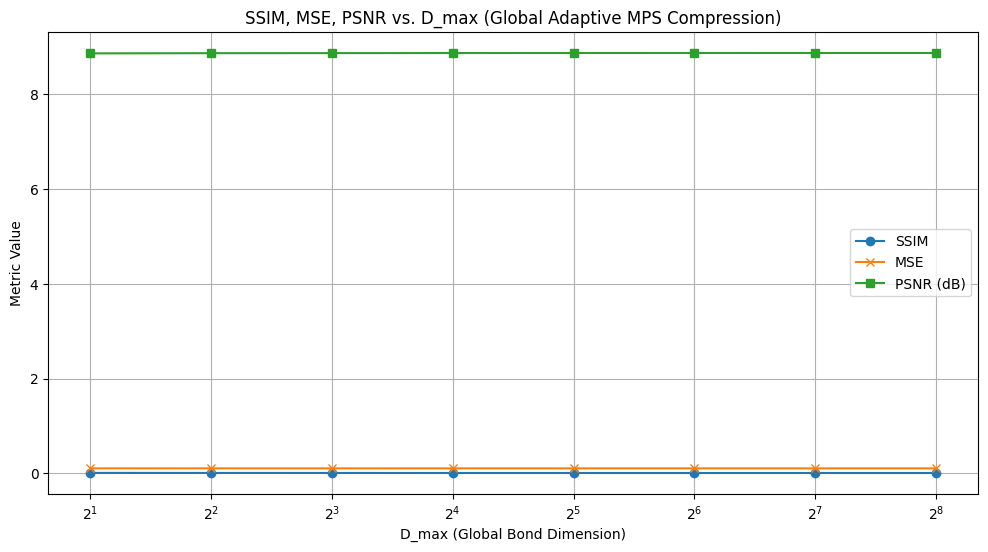

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Step 1: Flatten & reshape full image
def prepare_global_tensor(image):
    vec = image.flatten()
    vec /= np.linalg.norm(vec)
    L = int(np.log2(vec.size))
    psi_tensor = vec.reshape([2] * L)
    return psi_tensor, L

# Step 2: Settings
temp_original_image = new_img / 255.0
psi_tensor_base, L = prepare_global_tensor(temp_original_image)

bond_dims_to_test = [2, 4, 8, 16, 32, 64, 128, 256]
ssim_vals = []
mse_vals = []
psnr_vals = []

# Step 3: Test loop
for D_max in bond_dims_to_test:
    psi_tensor, L = prepare_global_tensor(temp_original_image)
    mps = vector_to_mps(psi_tensor, d=2, L=L, D_max=D_max)

    for site in range(1, L):
        adaptive_D = min(D_max, 2**min(site, L - site, 8))  # adaptive bond
        compress_state_at_bond(mps, d=2, D_new=adaptive_D, site=site, direction='toRight')

    rec_vec = reconstruct_from_MPS(mps, L)
    rec_img = rec_vec.reshape(temp_original_image.shape)

    # Metrics
    data_range = temp_original_image.max() - temp_original_image.min()
    ssim_score = ssim(temp_original_image, rec_img, data_range=data_range)
    mse_score = np.mean((temp_original_image - rec_img) ** 2)
    psnr_score = psnr(temp_original_image, rec_img, data_range=data_range)

    ssim_vals.append(ssim_score)
    mse_vals.append(mse_score)
    psnr_vals.append(psnr_score)

    print("D_max = {}, SSIM = {:.4f}, MSE = {:.5f}, PSNR = {:.2f} dB".format(D_max, ssim_score, mse_score, psnr_score))

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.xscale('log', base=2)
plt.plot(bond_dims_to_test, ssim_vals, marker='o', label='SSIM')
plt.plot(bond_dims_to_test, mse_vals, marker='x', label='MSE')
plt.plot(bond_dims_to_test, psnr_vals, marker='s', label='PSNR (dB)')
plt.xlabel('D_max (Global Bond Dimension)')
plt.ylabel('Metric Value')
plt.title('SSIM, MSE, PSNR vs. D_max (Global Adaptive MPS Compression)')
plt.legend()
plt.grid(True)
plt.show()
